In [ ]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tensorflow as tf
from tensorflow import keras

In [ ]:
def fmnist_tuner(hyper_parameters):
    # tuning parameters
    conv_units = hyper_parameters.Int('conv_units',
                                      min_value= 32,
                                      max_value=128,
                                      step = 32)
    dense_units = hyper_parameters.Int('dense_units',
                                       min_value=32,
                                       max_value=256,
                                       step=32)
    test_learning_rates = hyper_parameters.Choice('learning_rate',
                                                  values = [0.0001, 0.001, 0.01, 0.03,
                                                            0.05, 0.08, 0.1, 0.3])
    
    #model to tune
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(keras.layers.Conv2D(conv_units, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units = dense_units, activation = 'relu'))
    model.add(keras.layers.Dense(10, activation = 'softmax'))
    
    model.compile(optimizer=keras.optimizers.Nadam(learning_rate = test_learning_rates),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model  

In [ ]:
def plot_training(model_history, measure):
    plt.plot(model_history.history[measure])
    plt.plot(model_history.history['val_'+measure])
    plt.xlabel('Epochs')
    plt.ylabel(measure)
    plt.legend(['training '+ measure,'validation '+ measure])
    plt.show()



In [ ]:
#import the dataset
(training_images, training_labels),\
(validation_images, validation_labels) = keras.datasets.fashion_mnist.load_data()

# Normalize the image data
training_images = training_images.reshape(-1,28,28,1) / 255.0
validation_images = validation_images.reshape(-1,28,28,1) /255.0

In [ ]:
#verify data set shapes are as expected
print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

In [ ]:
batch_sizes=[2000,1500,1000,750,500,250,200,125,100,50,25]

optimal_hyperparameters = []

for size in batch_sizes:
    tuner= kt.Hyperband(fmnist_tuner,
                         objective='val_accuracy',
                         max_epochs=100,
                         factor=3,
                         directory='models',
                         project_name=f'fmnist_with_cnn_batch{size}')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)
    
    tuner.search(training_images, training_labels,
                 epochs = 100,
                 validation_split = 0.2,
                 batch_size=size,
                 callbacks = [stop_early])
    best_params = tuner.get_best_hyperparameters(num_trials=1)[0]
    dense_output = best_params.get('dense_units')
    learning_output = best_params.get('learning_rate')
    filters_output = best_params.get('conv_units')
    
    batch_results = (f'batch_size = {size}',
                     f'Dense units: {dense_output}',
                     f'Learning rate: {learning_output}',
                     f'Conv filters: {filters_output}'
)
    print(batch_results)
    optimal_hyperparameters.append(batch_results)

np.savetxt('optimal_hyperparameters.txt', 
           np.array(optimal_hyperparameters),
           fmt="%s")

In [ ]:
test1 = tuner.get_best_hyperparameters(num_trials=1)[0]
test1.get('val_accuracy')

In [ ]:
#Keras model for image classification
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8,(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(224, activation='relu'),
    tf.keras.layers.Dense(10, activation ='softmax')
])

model.compile(optimizer = keras.optimizers.Nadam(learning_rate = 0.001),
              loss ='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

In [8]:
history = model.fit(training_images, 
                    training_labels,
                    validation_data = (validation_images, validation_labels),
                    epochs=100,
                    batch_size = 500,
                    verbose=1
                   )

Epoch 1/100
240/240 [==============================] - 11s 29ms/step - loss: 0.4728 - accuracy: 0.8321 - val_loss: 0.3234 - val_accuracy: 0.8849
Epoch 2/100
240/240 [==============================] - 7s 28ms/step - loss: 0.2823 - accuracy: 0.8977 - val_loss: 0.2739 - val_accuracy: 0.9004
Epoch 3/100
240/240 [==============================] - 7s 28ms/step - loss: 0.2281 - accuracy: 0.9167 - val_loss: 0.2495 - val_accuracy: 0.9076
Epoch 4/100
240/240 [==============================] - 7s 28ms/step - loss: 0.1912 - accuracy: 0.9298 - val_loss: 0.2429 - val_accuracy: 0.9086
Epoch 5/100
240/240 [==============================] - 7s 28ms/step - loss: 0.1605 - accuracy: 0.9410 - val_loss: 0.2366 - val_accuracy: 0.9142
Epoch 6/100
240/240 [==============================] - 7s 28ms/step - loss: 0.1323 - accuracy: 0.9517 - val_loss: 0.2316 - val_accuracy: 0.9220
Epoch 7/100
240/240 [==============================] - 7s 28ms/step - loss: 0.1077 - accuracy: 0.9615 - val_loss: 0.2499 - val_accuracy

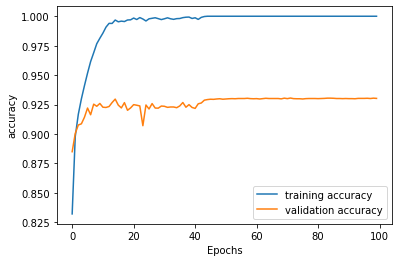

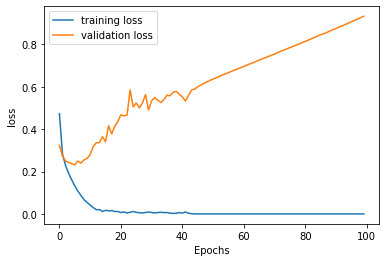

In [9]:
plot_training(history, 'accuracy')
plot_training(history, 'loss')

In [7]:
pip install numba

Note: you may need to restart the kernel to use updated packages.
